In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dependecy depreciation
np.float = float    
np.int = int  
np.object = object   
np.bool = bool

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.efficient_frontier import EfficientFrontier

from scipy.stats import norm, anderson, t, skewnorm, skewtest
# import statsmodels.api - inconsistent module cannot be used


## 1. Portfolio Risk and Return

### 1.1 Portfolio Returns during crisis

In [7]:
portfolio = pd.read_csv("crisis_portfolio.csv", index_col='Date')
portfolio.index = pd.to_datetime(portfolio.index,format = '%d/%m/%Y')
print(portfolio.head())

returns = portfolio.pct_change()
weights = [0.25, 0.25, 0.25, 0.25]
portfolio_returns = returns.dot(weights)

              Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Date                                                              
2004-12-31  481.799988       55.520000     104.040001    39.009998
2005-01-03  482.700012       55.900002     104.949997    39.150002
2005-01-04  478.600006       55.299999     104.269997    38.410000
2005-01-05  484.600006       54.980000     103.800003    38.490002
2005-01-06  489.299988       56.279999     105.230003    38.709999


              Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Date                                                              
2008-02-01  296.899994       48.250000     207.779999    48.250000
2008-02-04  292.200012       48.029999     200.800003    46.220001
2008-02-05  270.500000       45.560001     189.860001    43.889999
2008-02-06  269.200012       44.950001     187.169998    43.720001
2008-02-07  267.000000       44.880001     190.460007    45.110001


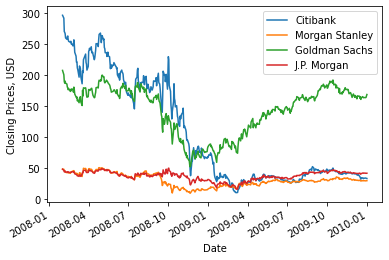

In [25]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['02/01/2008':'31/12/2009']
print(asset_prices.head())

# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel("Closing Prices, USD")
plt.show()

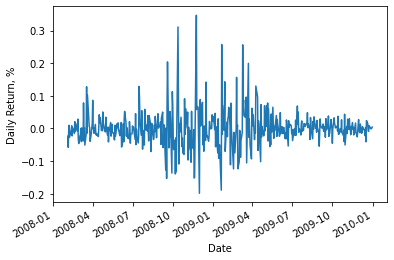

In [26]:
# Compute the portfolio's daily returns
asset_returns = asset_prices.pct_change()
portfolio_returns_crisis = asset_returns.dot(weights)

# Plot portfolio returns
portfolio_returns_crisis.plot().set_ylabel("Daily Return, %")
plt.show()

### 1.2 Asset Covariance during crisis

In [5]:
# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Scale covariance annually
covariance = covariance * 252

print(covariance)

                Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        1.526224        0.850605       0.590932     0.745771
Morgan Stanley  0.850605        1.343898       0.681356     0.575239
Goldman Sachs   0.590932        0.681356       0.515569     0.437167
J.P. Morgan     0.745771        0.575239       0.437167     0.699362


### 1.3 Portfolio Volatility during crisis

In [6]:
# Portfolio volatility for 2008 to 2009
portfolio_variance = np.transpose(weights) @ covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)
print(portfolio_volatility)

0.8604938970533907


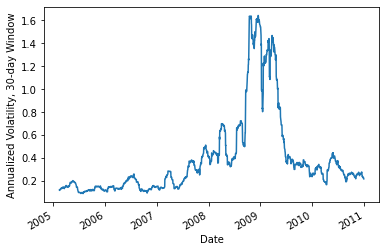

In [7]:
# 30-day rolling window of portfolio returns
returns_windowed = portfolio_returns.rolling(30)

# Annualize volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

### 1.4 Risk Factor Correlation
We will be using quarterly mortgage delinquency rates from 2005 to 2009 to compare with the portfolio returns

In [8]:
mort_del = pd.read_csv("mortgage_delinquency.csv", index_col='Date')
mort_del.head()

,Mortgage Delinquency Rate
Date,
2005-03-31,0.0155
2005-06-30,0.0159
2005-09-30,0.0163
2005-12-31,0.0161
2006-03-31,0.0162


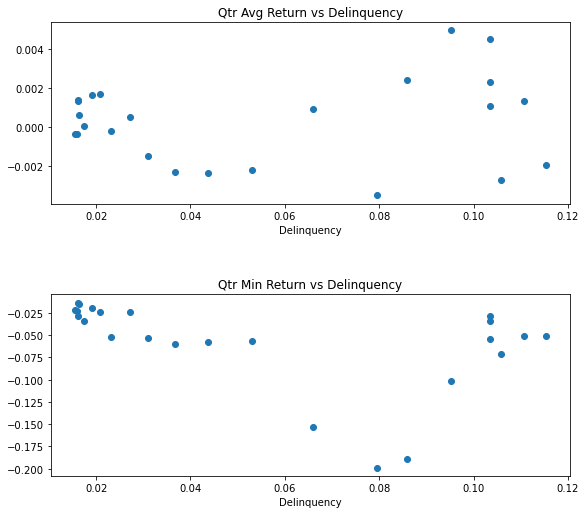

In [9]:
# Convert daily portfolio_returns into quarterly avg and min returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()

# Plot relationship of quarterly avg and min with delinquency rates
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(9)

ax1.set_title('Qtr Avg Return vs Delinquency')
ax1.scatter(mort_del, portfolio_q_average)
ax1.set_xlabel('Delinquency')

ax2.set_title('Qtr Min Return vs Delinquency')
ax2.scatter(mort_del, portfolio_q_min)
ax2.set_xlabel('Delinquency')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0, 
                    hspace=0.5)
plt.show()

The plots suggest there is weak correlation between average returns and deliquency rates. But there looks to be negative correlation between minimum returns and deliquency rates

### 1.5 Efficient Frontier
Here we will calculate thee efficient frontier to visualize the risk-return tradeoffs of portfolios. We will investigate the efficient frontiers throughout 3 subperiods (before, during, and after crisis)

Periods are 2005-2006 (before), 2007-2008 (during), 2009-2010 (after)

##### Step 1 - segregate periods between 2005 to 2010 and get expected returns and covariance matrix for each period

In [10]:
# Create a dictionary of time periods 
epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

# Compute the expected returns and efficient covariance for each epoch
e_exp = {}
e_cov = {}
for x in epochs.keys():
  sub_price = portfolio.loc[epochs[x]['start']:epochs[x]['end']]
  e_exp[x] = mean_historical_return(sub_price, frequency=252)
  e_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

# Display the efficient covariance matrices for all epochs
print("Expected Returns\n", e_exp)
print("Efficient Covariance Matrices\n", e_cov)

Expected Returns
 {'before': Citibank          0.074516
Morgan Stanley    0.207847
Goldman Sachs     0.379977
J.P. Morgan       0.111193
dtype: float64, 'during': Citibank         -0.652236
Morgan Stanley   -0.557410
Goldman Sachs    -0.352148
J.P. Morgan      -0.190451
dtype: float64, 'after': Citibank         -0.184163
Morgan Stanley    0.269505
Goldman Sachs     0.391871
J.P. Morgan       0.161314
dtype: float64}
Efficient Covariance Matrices
 {'before':                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.018149        0.013789       0.013183     0.013523
Morgan Stanley  0.013789        0.043021       0.030559     0.016525
Goldman Sachs   0.013183        0.030559       0.044482     0.018237
J.P. Morgan     0.013523        0.016525       0.018237     0.024182, 'during':                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.713035        0.465336       0.323977     0.364848
Morgan Stanley  0.465336        0.994390    

##### Step 2 - gather efficient frontier for each period

In [11]:
# Initialize the Crtical Line Algorithm object
efficient_portfolio_before = CLA(e_exp['before'], e_cov['before'])
efficient_portfolio_during = CLA(e_exp['during'], e_cov['during'])
efficient_portfolio_after = CLA(e_exp['after'], e_cov['after'])

# Compute the efficient frontier
(ret_bef, vol_bef, weights) = efficient_portfolio_before.efficient_frontier()
(ret_dur, vol_dur, weights) = efficient_portfolio_during.efficient_frontier()
(ret_aft, vol_aft, weights) = efficient_portfolio_after.efficient_frontier()

##### Plot efficient frontiers

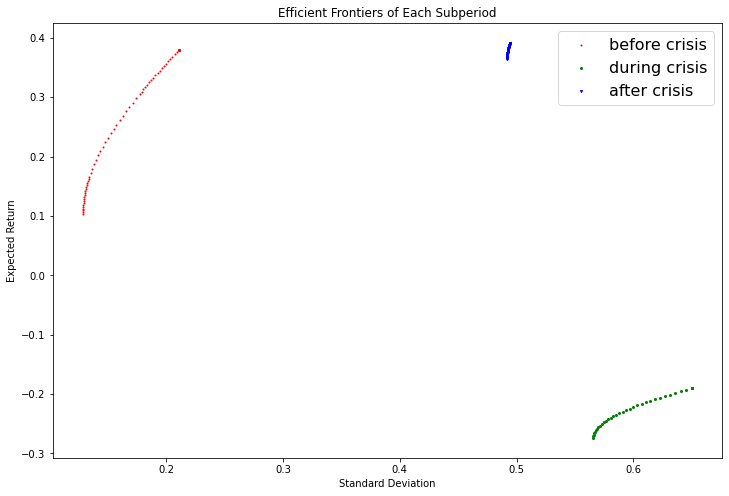

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(vol_bef, ret_bef, s = 4, c = 'r', marker = '.', label = 'before crisis')
plt.scatter(vol_dur, ret_dur, s = 4, c = 'g', marker = 'o', label = 'during crisis')
plt.scatter(vol_aft, ret_aft, s = 4, c = 'b', marker = 'v', label = 'after crisis')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontiers of Each Subperiod')
plt.legend(fontsize=16)
plt.show()

&nbsp;

## 2. Risk Metrics and Mitigation

### 2.1 Metrics

#### 2.1.1 95% VaR and CVaR under Normal distribution of portfolio returns
We will also investigate whether the normal distribution fits the loss data well using the Anderson normality test, which tests the null hypothesis that the data given follows a normal distribution

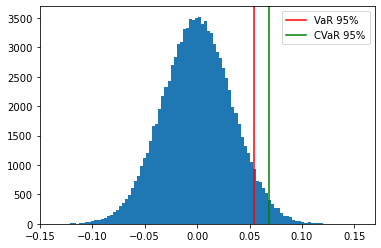

Anderson-Darling test result:  AndersonResult(statistic=86.43196190834192, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [13]:
# Compute the mean and standard deviation of the portfolio returns
pm = portfolio_returns.mean()
ps = portfolio_returns.std()

# Compute the 95% VaR 
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR 95%")
plt.axvline(x = CVaR_95, c='g', label = "CVaR 95%")
plt.legend()
plt.show()

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(portfolio_returns.dropna()))

The Anderson test statistic 86.43 exceeds the ciritical value 1.089 under significance level 0.01, indicating there is very strong evidence that the null hypothesis is false. So the normal distribution may be a poor representation of the data

#### 2.1.2 99% VaR under t-distribution of portfolio returns

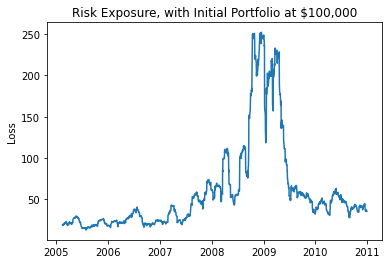

In [14]:
# Create rolling window parameter list
mu_t_30 = portfolio_returns.rolling(30).mean()
sigma_t_30 = portfolio_returns.rolling(30).std()
rolling_parameters_t_30 = [(29, mu_t_30[i], s) for i,s in enumerate(sigma_t_30)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99_t_30 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters_t_30 ] )

# Plot the minimum risk exposure over the 2005-2010 time period
date_array = np.array(portfolio_returns.index.to_pydatetime(), dtype=np.datetime64)
plt.plot(date_array, 0.01 * VaR_99_t_30 * 100000)
plt.ylabel('Loss')
plt.title('Risk Exposure, with Initial Portfolio at $100,000')
plt.show()

#### 2.1.3 99% CVaR under t-distribution of portfolio returns during crisis (2008-2009)

In [15]:
# Fit the Student's t distribution to crisis losses
p = t.fit(portfolio_returns.loc['01/01/2008':'31/12/2009'])

# Compute the VaR_99 for the fitted distribution
VaR_99_t_crisis = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss_t_crisis = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99_t_crisis)
CVaR_99_t_crisis = (1 / (1 - 0.99)) * tail_loss_t_crisis
print(CVaR_99_t_crisis) 

0.33326005732581226


### 2.2 Mitigation

#### 2.2.1 Minimizing CVaR 
Our goal here is to gather optimal asset weights to minimize CVaR at 95% confidence level for default

In [16]:
# Create the efficient frontier for CVaR minimization
ec = EfficientCVaR(None, returns.dropna())

# Find the CVaR-minimizing portfolio weights at the default 95% confidence level
optimal_weights = ec.min_cvar()

# Map the values in optimal_weights to the bank names
names = {0: 'Citibank', 1: 'Morgan Stanley', 2: 'Goldman Sachs', 3: 'J.P. Morgan'}
optimal_weights = { names[i] : optimal_weights[i] for i in optimal_weights}

# Display the optimal weights
print(optimal_weights)

{'Citibank': 1.2e-14, 'Morgan Stanley': 1.4e-15, 'Goldman Sachs': 0.669324359403484, 'J.P. Morgan': 0.3306756405965026}


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


#### 2.2.2 Minimizing CVaR during crisis periods
This time we will get optimal asset weights to minimize 95% CVaR for periods of before (2005-2006), during (2007-2008), and after (2008-2009) crisis. Then we will compare these weights with weights from the minimum volatility portfolio

##### &emsp; Step 1 - Gather min-CVaR portfolio weights

In [17]:
# Create dictionary of returns for each period (epochs can be found in section 1.5)
returns_dict = {}
for x in epochs.keys():
  returns_dict[x] = returns.loc[epochs[x]['start']:epochs[x]['end']]

# Initialize the efficient portfolio dictionary
ec_dict = {}

# For each epoch, assign an efficient frontier CVaR instance to ec
for x in ['before', 'during', 'after']: 
    ec_dict[x] = EfficientCVaR(None, returns_dict[x])

# Initialize the dictionary of optimal weights
opt_wts_dict = {}

# Find and display the CVaR-minimizing portfolio weights at the default 95% confidence level
for x in ['before', 'during', 'after']:
    opt_wts_dict[x] = ec_dict[x].min_cvar()
    # map bank names to optimal weights
    opt_wts_dict[x] = {names[i] : [opt_wts_dict[x][i]] for i in opt_wts_dict[x]}

print("CVaR:\n", pd.DataFrame.from_dict(opt_wts_dict))    

CVaR:
                               before                during  \
Citibank        [0.4609477943301659]           [1.282e-13]   
Morgan Stanley  [0.0549059865334676]            [1.59e-14]   
Goldman Sachs   [0.0153721405973319]  [0.6973599489090844]   
J.P. Morgan     [0.4687740785390346]  [0.3026400510907716]   

                               after  
Citibank        [0.0305962815568765]  
Morgan Stanley           [8.325e-13]  
Goldman Sachs   [0.9694037184417414]  
J.P. Morgan              [5.493e-13]  


##### &emsp; Step 2 - Gather min-volatility portfolio weights

In [18]:
# Initialize the efficient portfolio dictionary
ef_dict = {}

# For each epoch, assign an efficient frontier instance to ef 
# recall e_cov is a dictionary of covariance matrix for each period, section 1.5
for x in ['before', 'during', 'after']: 
    ef_dict[x] = EfficientFrontier(None, e_cov[x])

# Initialize the dictionary of optimal weights
min_wts_dict = {}

# Find and display the CVaR-minimizing portfolio weights at the default 95% confidence level
for x in ['before', 'during', 'after']:
    min_wts_dict[x] = ef_dict[x].min_volatility()
    
print("Min Volatility:\n", pd.DataFrame.from_dict(min_wts_dict))    

Min Volatility:
                   before   during     after
Citibank        0.657653  0.00000  0.000000
Morgan Stanley  0.048006  0.00000  0.034332
Goldman Sachs   0.040377  0.51799  0.863004
J.P. Morgan     0.253963  0.48201  0.102664


Notice Goldman Sachs is always held in each period for both the min-CVaR and min-volatility portfolios

&nbsp;

### 3. More Risk Metrics 
Here we will cover estimating risk measures via parametric and non-parametric estimation. Monte Carlo Simulation will also be used to predict uncertainty, including structural breaks based on the crisis

We will focus on the portfolio losses in subperiods of the crisis - i.e before (2005-2006), during (2007-2008), and after (2008-2009) crisis

In [19]:
# losses in subperiods of crisis (epochs contains the start and end dates for each subperiod)
weights = [0.25, 0.25, 0.25, 0.25]
losses_dict = {}
for x in epochs.keys():
  losses_dict[x] = returns_dict[x].dot(weights)

#### 3.1 Parametric Estimation: Skewed Normal

**First we will check goodness of fit using skewtest where $H_0$: &nbsp; skewness of data = 0**

In [20]:
# Test the data for skewness
skew_dict = {'index': ['T-stat', 'p-value']}
for x in epochs.keys():
    skew_dict[x] = skewtest(losses_dict[x])
    
pd.DataFrame.from_dict(skew_dict)

,index,before,during,after
0,T-stat,0.510823,1.121091e+01,9.864065e+00
1,p-value,0.609475,3.604490e-29,5.958717e-23


Here we see the p-values from the skewtest and it looks there is very strong evidence against the null hypothesis under the periods 'during' and 'after', while there is no evidence under 'before' period. So this suggests that the data for 'during' and 'after' periods are skewed.

**Next we will estimate 95% VaR from the skew-normal distribution fore ach period**

In [21]:
# Test the data for skewness
var95_skew_dict = {'index': ['95% VaR']}
for x in epochs.keys():
    params = skewnorm.fit(losses_dict[x])
    var95_skew_dict[x] = [skewnorm.ppf(0.95, *params)]
    
pd.DataFrame.from_dict(var95_skew_dict)

,index,before,during,after
0,95% VaR,0.016174,0.071569,0.064144


#### 3.2 Monte Carlo Simulation
We will estimate 95% VaR for each period using Monte Carlo Simulation

In [22]:
# Initialize daily cumulative loss for the 4 assets, across N runs. 
# Number of steps (minutes) in a day is set to 1440 minutes
N = 10000
total_steps = 1440     
loss_dict = {'index': ['95% VaR']}

# Create the Monte Carlo simulations for N runs. From section 1.5 we will use
# e_exp and e_cov which are the mean losses and covariance matrix resp.
for x in epochs.keys():
    daily_loss = np.zeros((4, N))
    for n in range(N):
        # Compute simulated path of length total_steps for correlated returns
        correlated_randomness = (e_cov[x].values) @ norm.rvs(size = (4,total_steps))
        # Adjust simulated path by total_steps and mean of portfolio losses
        steps = 1/total_steps
        minute_losses = (e_exp['during'].values.reshape((4,1))) * (1/total_steps) + correlated_randomness * np.sqrt(1/total_steps)
        daily_loss[:, n] = minute_losses.sum(axis=1) 
        loss_dict[x] = [np.quantile(weights @ daily_loss, 0.95)]
        
pd.DataFrame.from_dict(loss_dict)

,index,before,during,after
0,95% VaR,-0.365649,0.988492,0.685812


#### 3.3 Structural Break
We will investigate whether there was a "structural" change between 2005 and 2010. Here we will consider several relationships to identify any changes

**Part 1 - Quarterly Minimum Portfolio Values and Return Volatility**

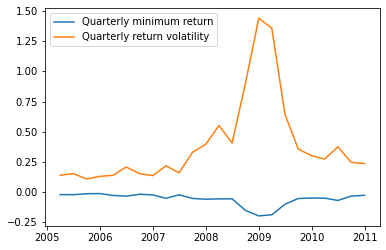

In [23]:
portfolio_q_vol = portfolio_returns.resample('Q').std().dropna()*np.sqrt(252)

# Create a plot of quarterly minimum portfolio returns
plt.plot(portfolio_q_min, label="Quarterly minimum return")

# Create a plot of quarterly volatility
plt.plot(portfolio_q_vol, label="Quarterly return volatility")

# Create legend and plot
plt.legend()
plt.show()

There looks to be a change between the first half of 2008. We will investigate if this change is a temporary 'blip' or something structural

**Factor Model Relationship between Quarterly Minimum Portfolio Values and Mortgage Delinquencies** &nbsp;  
We will use the mortgage delinquency dataset (section 1.4) and identify (if any) a relationship with the minimum portfolio values using an OLS regression from 2005 to 2010

In [ ]:
# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

# Regress quarterly minimum portfolio returns against mortgage delinquencies
result = sm.OLS(port_q_min, mort_del).fit()

# Retrieve the sum-of-squared residuals
ssr_total = result.ssr
print("Sum-of-squared residuals, 2005-2010: ", ssr_total)

<span style="color:red">**Inconsistent module present so there is no output**</span>&nbsp;    
But the value is SSR = 0.05039331102490133. 

We will use this value for the Chow Test in which $H_0$: &nbsp; structural break on June 30, 2008

**Chow Test** &nbsp;  
Here we will identify whether there is evidence against the null hypothesis of a structural break on June 30, 2008 (first half of 2008). Note the Chow Test Statistic follows an F-distribution

In [ ]:
# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(before['mort_del'])
after_with_intercept  = sm.add_constant(after['mort_del'])

# Fit OLS regressions to each sub-period
r_b = sm.OLS(before['returns'], before_with_intercept).fit()
r_a = sm.OLS(after['returns'],  after_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
# Compute and display the Chow test statistic
numerator = ((ssr_total - (ssr_before + ssr_after)) / 2)
denominator = ((ssr_before + ssr_after) / (24 - 4))
print("Chow test statistic: ", numerator / denominator)

<span style="color:red">**Inconsistent module present so there is no output**</span> &nbsp;  
Chow test statistic:  28.931473605474807

Critical F-value at 99% confidence: 5.85

As the test statistic is greater than the critical value, it suggests that there is no evidence against the null hypothesis. This indicates that there is a structural break in the data in the middle of 2008

**Part 2 - Volatility Structural Break**  
Here we will visual volatility changes to help reveal possible structural break points in the time series. Identifying when volatility appears to change can be used as a break point for further analysis in structural breaks (like Chow Test)


We will examine plots of volatility of the portfolio from 2008-2009. One plot will be the portfolio currently used, while the others will be the same equal-weighted portfolio but without one of the stocks

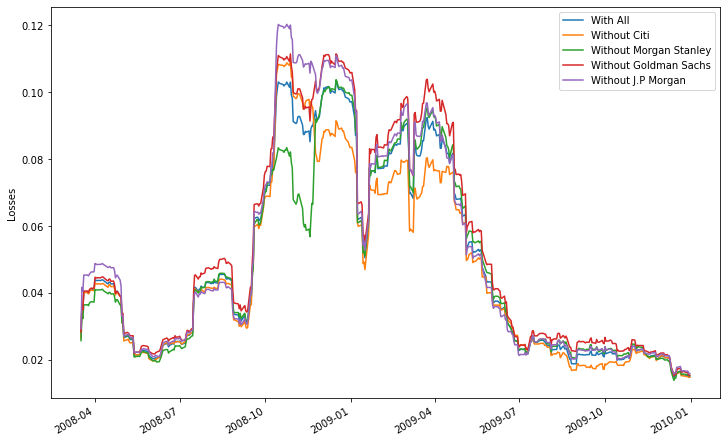

In [44]:
# Find the time series of returns with and without one of the stocks
# asset_returns contains returns of the stocks from 2008-2009 (defined in section 1.1)
weights_dict = {'With All': weights, 'Citi': [0, 1/3, 1/3, 1/3], 'Morgan Stanley': [1/3, 0, 1/3, 1/3],
                'Goldman Sachs': [1/3, 1/3, 0, 1/3], 'J.P Morgan': [1/3, 1/3, 1/3, 0]}
vol = pd.DataFrame()

for x in ['With All', 'Citi', 'Morgan Stanley', 'Goldman Sachs', 'J.P Morgan']:
    ret_without = asset_returns.dot(weights_dict[x])
    if x == "With All":
        vol_without = ret_without.rolling(30).std().dropna().rename("With All")
    else:
        vol_without = ret_without.rolling(30).std().dropna().rename(f"Without {x}")
    vol = pd.concat([vol, vol_without], axis=1)
   

vol.plot(figsize=(12,8)).set_ylabel("Losses")
plt.show()

This indicates that each of the individual stock's volatility alone does not increase the portfolio volatility during the crisis as the standard portfolio volatility follows a similar trend with the others. This supports the possibility of a structural break around mid 2008.

&nbsp; 

### 4. Advanced Risk Measurement
Here we will cover advanced techniques in estimating extreme events, including neural networks to approximate loss distributions and portfolio optimization

In [96]:
# General Electric Stock
ge = pd.read_csv('GE - Historical.csv', index_col = 'Date')
print(ge.head(), '\n')

ge_losses = ge['Adj Close'].pct_change()
print(ge_losses.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2007-01-03  35.971153  36.682693  35.942307  36.509617  23.483156  44951700
2007-01-04  36.509617  36.538460  36.009617  36.298077  23.347090  32540300
2007-01-05  36.125000  36.307693  35.875000  36.115383  23.229588  28108200
2007-01-08  36.009617  36.221153  35.817307  36.105770  23.223402  24662200
2007-01-09  36.326923  36.528847  35.923077  36.105770  23.223402  25581200 

Date
2007-01-03         NaN
2007-01-04   -0.005794
2007-01-05   -0.005033
2007-01-08   -0.000266
2007-01-09    0.000000
Name: Adj Close, dtype: float64


#### 4.1 Extreme Value Theory

**Block Maxima**  
Here we will examine time series of block maxima for General Electric during the crisis period

In [98]:
# Convert daily portfolio_returns into quarterly avg and min returns
weekly_maxima = ge_losses.resample("W").max().dropna()
monthly_maxima = ge_losses.resample("M").max().dropna()
quarterly_maxima = ge_losses.resample("Q").max().dropna()

# Plot relationship of quarterly avg and min with delinquency rates
# date_ge = np.array(ge_losses.index.to_pydatetime(), dtype=np.datetime64)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(7)
fig.set_figwidth(9)

ax1.plot(date_ge, weekly_maxima, label = "Weekly Maxima")
plt.figure("weekly")

axis_2.plot(date_ge, monthly_maxima, label = "Monthly Maxima")
plt.figure("monthly")

axis_3.plot(date_ge, quarterly_maxima, label = "quaterly maxima")
plt.figure("quarterly")


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0, 
                    hspace=0.5)
plt.show()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'